<img src="./img/HWNI_logo.svg"/>

# Lab 08 - Visualizing Models

In [51]:
%matplotlib notebook

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

import pandas as pd

# choose colors that work for most color-blind folks
sns.set_palette("colorblind")
sns.set(color_codes=True)

import util.lab07utils as utils

from ipywidgets import interact
#from ipywidgets import interact,interactive fixed, interact_manual
import ipywidgets as widgets

In [4]:
import inspect
import math

class Parameters(object):
    
    def __init__(self,defaults,ranges,names=None):
        assert len(defaults) == len(ranges), "must have default and range for each parameter"
        
        self.values = np.atleast_2d(defaults)
        
        self.num = len(defaults)
        
        self._zip = zip(defaults,ranges)
        
        if names == None:
            self.names = ['parameter_'+str(idx) for idx in range(self.num)]
        else:
            self.names = names
        
        self.dict = dict(zip(self.names,np.squeeze(self.values)))
        
        self.defaults = defaults
        self.ranges = ranges
        
        self.makeWidgets()
        
    def makeWidgets(self):
        self._widgets = [self.makeWidget(parameter,idx) 
                        for idx,parameter
                        in enumerate(self._zip)]
        
        self.widgets = {self.names[idx]:_widget
                        for idx,_widget
                       in enumerate(self._widgets)}
    
    def makeWidget(self,parameter,idx):
        default = parameter[0]
        range = parameter[1]
        name = self.names[idx]
        return widgets.FloatSlider(value=default,
                                    min= range[0],
                                   max = range[1],
                                   step = 0.01,
                                   description=name
                                    )
    
    def update(self):
        sortedKeys = sorted(self.dict.keys())
        self.values = np.atleast_2d([self.dict[key] for key in sortedKeys])
        
        
class Model(object):
    
    def __init__(self,inputValues,modelInputs,parameters,funk):
        self.modelInputs = np.atleast_2d(modelInputs)
        self.inputValues = inputValues
        self.parameters = parameters
        self.funk = funk
        self.plotted = False
        
    def plot(self):
        if not self.plotted:
            self.initializePlot()
        else:
            self.artist.set_data(self.inputValues,self.outputs)
        return
    
    @property
    def outputs(self):
        return np.squeeze(self.funk(self.modelInputs))
    
    def initializePlot(self):
        self.fig = plt.figure()
        self.ax = plt.subplot(111)
        self.artist, = plt.plot(self.inputValues,
                                self.outputs,
                               linewidth=4)
        self.plotted = True
        self.ax.set_ylim([-10,10])
        self.ax.set_xlim([-10,10])
    
    def makeInteractive(self):
        @interact(**self.parameters.widgets)
        def make(**kwargs):
            frame = inspect.currentframe()
            args, _, _, values = inspect.getargvalues(frame)
            kwargs = values['kwargs']
            for parameter in kwargs.keys():
                self.parameters.dict[parameter] = kwargs[parameter]
            self.parameters.update()
            self.plot()
            return
        
        return
    
class LinearModel(Model):
    
    def __init__(self,inputValues,parameters,modelInputs=None):
        
        if modelInputs == None:
            modelInputs = self.transformInputs(inputValues)
        else:
            modelInputs = modelInputs
        
        def funk(inputs):
            return np.dot(self.parameters.values,inputs)
        
        Model.__init__(self,inputValues,modelInputs,parameters,funk)
        
    def transformInputs(self,inputValues):
        modelInputs = [[1]*inputValues.shape[0],inputValues]
        return modelInputs
    
class LinearizedModel(LinearModel):
    
    def __init__(self,transforms,inputValues,parameters):
        
        self.transforms = [lambda x: np.power(x,0), 
                           lambda x: x] + transforms
        
        modelInputs = self.transformInputs(inputValues)
            
        LinearModel.__init__(self,inputValues,parameters,modelInputs=modelInputs)
        
    def transformInputs(self,inputValues):
        transformedInputs = []
        
        for transform in self.transforms:
            transformedInputs.append(transform(inputValues))
            
        return transformedInputs
    
class NonlinearModel(Model):
    
    def __init__(self):
        pass

In [5]:
def makeDefaultParameters(number,rnge=1,names=None):
    defaults = [0]*number
    ranges = [[-rnge,rnge]]*number
    return Parameters(defaults,ranges,names)

def makeSineParameters(degree):
    defaults = [(-1)**(n//2)/math.factorial(n) 
                if n%2 != 0 
                else 0 
                for n in range(maxDegree+1)]
    ranges = [[-1,1]]*(degree+1)
    return Parameters(defaults,ranges,names=makePolynomialParameterNames(degree))

def makePolynomialTransforms(maxDegree):
    curried_power_transforms = [lambda n: lambda x: np.power(x,n) for _ in range(2,maxDegree+1)]
    transforms = [curried_power_transform(n) 
                              for curried_power_transform,n
                                  in zip(curried_power_transforms,range(2,maxDegree+1))
                 ]
    return transforms

def makePolynomialParameters(maxDegree,rnge=1):
    return makeDefaultParameters(maxDegree+1,rnge=rnge,
                                 names=makePolynomialParameterNames(maxDegree))

def makePolynomialParameterNames(maxDegree):
    return ['x^'+str(n) for n in range(maxDegree+1)]

def makeLinearParameters():
    return makePolynomialParameters(1)

In [48]:
def randomWeights(d=1):
    return np.random.standard_normal(size=(d,1))

# Introduction

When we model the relationship between two observed variables, we need the following ingredients:

- a function, which we'll call the *modelling function*, that takes one of the variables as its input and produces a guess for what the other variable is as its output
- a "noise term" that specifies what we expect our errors to look like

Let's write these mathematically. We'll denote our input variable as $x$ and the variable we are trying to predict as $y$ (because [that's what Descartes did in 1637](http://math.stackexchange.com/questions/2936/why-are-x-and-y-such-common-variables-in-todays-equations-how-did-their-use-or/)). We'll call the guess generated by our model $\hat{y}$. We will auspiciously call our errors $\epsilon$ (pronounced "epp-sih-lawn"), since we hope for them to be small, and $\epsilon$ is the traditional symbol for "very small, but not 0". Our errors are random (or else we'd try to predict them!) and so they have a probability distribution, $p(\epsilon)$. When we want to say some random number is distributed according to some distribution, we write $x \sim p(x)$.

Putting all of that together, here's how we write down the problem of modeling the relationship between two variables, $x$ and $y$:


$$
\hat{y} = f(x) \\
\epsilon \sim p(\epsilon)\\
y = \hat{y} + \epsilon
$$

In all of the models below, we will assume that $p(\epsilon)$ is a normal distribution with a mean of $0$ and some standard deviation $\sigma$. This will come up frequently enough that we need a special symbol for it. The most common version is with a fancy (aka "script") $N$: $\mathcal{N}(\mu,\sigma)$. Combining our assumption with our new notation, we can rewrite our equations:


$$
\hat{y} = f(x) \\
\epsilon \sim \mathcal{N}(0,\sigma)\\
y = \hat{y} + \epsilon
$$

Some things to note: since $\epsilon$ is random, $y$ is random. That means that our model specifies a distribution for $y$, and we know exactly what it is. Below, we'll visualize this distribution. Also, notice that changing $f$ is the only way we can change our model. Below, we'll also visualize some common choices for $f$.

## Linear Models

Linear models are the simplest class of models. The assumption of linearity is both strong -- it greatly reduces the things we can potentially model -- and powerful -- as we'll see next week, it makes modelling much easier!

### Specifying Linear Models

In a linear model, $f$ is a linear function. If $x$ is a number, that means $f$ is just a number to multiply $x$ by. If $x$ is a vector, that means $f$ is a vector that we multiply $x$ by -- remember that, in the case of vectors, "multiply" means "compute the dot product between".

The dot product is also sometimes called the *weighted sum*. Because of this, we call the $f$ vector the "weight vector", alias $w$.

Putting this together, we can specify the linear model as

$$
y =  w \cdot x + \epsilon
$$

The dot product can be written in many ways. Below, we'll find it useful to write it as

$$
y = w^T x + \epsilon
$$

where $w^T$ means "w-transposed", or flipped on its side.

This is slightly different from the way that the lecture notes write down the linear model, but in my opinion, it makes the math easier to follow.

The only differences are in the order things are written down and the shapes of the various arrays. Remember that, unlike in regular multiplication, when we're doing matrix-vector multiplication, we need to keep a close eye on the shapes of our matrices and vectors. 

#### Tracking Array Shapes

For a matrix that has $r$ rows and $c$ columns, the shape is written as $(r, c)$. We can only add matrices or vectors that are the same shape. We can only multiply two matrices or vectors when the number of *columns* in the first matches the number of *rows* in the second. The resulting matrix or vector has the same number of *rows* as the first and the same number of *columns* as the second. This sounds complicated, but it's actually not! We can write down a "shape equation" that's analogous to the "unit equations" used in physics and chemistry:

$$
(A,B)\cdot(B,C) = (A,C) \\
(A,B) + (A,B) = (A,B)
$$

Before writing down code that involves matrices and vectors, it's useful to sit down and write out what the shape of each vector or matrix will be, and to write shape equations for each of the multiplications you're going to do. This helps you make sure you've got everything straight before the coding starts.

Following tradition in math, we'd like our vectors to be *column vectors*. That means that a two-dimensional vector, say for $x$ or $y$, would look like

$$
\left[\begin{array}{c}
x_1 \\ x_2
\end{array}\right]
$$

The shape of such a vector is $(2,1)$. More generally, it's $(D,1)$, where $D$ is the number of dimensions.

Our weight vector will also be a column vector. If we try to multiply our data vector by our weight vector directly, we get $(D,1)\cdot(D,1)$, which doesn't work! We can make it work by "flipping" weight vector -- making its shape $(1,D)$ instead of $(D,1)$. This is why we needed the transpose when we wrote the linear model above. To belabor the point, the weight vector $w$ would be written 

$$
\left[\begin{array}{c}
w_1 & w_2
\end{array}\right]
$$

Now, we can write down a shape equation for the linear model and make sure we've got everything right.

$$
y = w^T x +\epsilon \\
(1,1) = (1,D)\cdot(D,1) + (1,1)
$$

Awesome!

#### Calculating Multiple Outputs at Once

Above, we calculated a single output $y$ for a single input $x$. In order to get outputs for more than one input, we could write a for-loop over inputs and get a list of outputs, but this would be fairly inefficient.

Instead, we can write the calculation for multiple data points as *one matrix-vector multiplication* and get them all at once! If these seems crazy, remember that we came up with matrix and vector multiplication to keep track of multiple linear equations being solved at once.

The only change to everything above is that now, instead of $x$ being a $(D,1)$ vector, it's now a $(D,N)$ matrix, where $N$ is the total number of data points. You can think of it like a sardine can full of $(D,1)$ vectors, all lined up next to each other.

Let's adjust just the $x$ part of our shape equation and see what happens.

$$
y = w^T x +\epsilon \\
(?,?) = (1,D)\cdot(D,N) + (1,1)
$$

But this isn't right! The shape we get from $w^T x$ is $(1,N)$, and we're trying to add a $(1,1)$ vector to it! We can fix this by making $\epsilon$ a $(1,N)$ vector. Just as we had a "sardine can" matrix of input vectors, here we have a "sardine can" vector of error values.

With this correction, our shape equation is now:

$$
y = w^T x +\epsilon \\
(1,N) = (1,D)\cdot(D,N) + (1,N)
$$

which works!

#### Taking Care of the Y-intercept

One of the things we learned about linear functions is that they don't move the origin. Because of this, a linear function of numbers has to output $0$ whenever the input is $0$ -- the $y$-intercept is always $0$!

This is too much of a restriction! We can "cheat" to get around this by augmenting our data. We simply add an additional dimension to our inputs and make the value of $x$ in this dimension always equal to $1$. Like all the other values, this will be multiplied by some weight in $w$ and added to the output, but unlike the other values, the result will be the same for every data point. If the weight, $w_0$, that we multiply it by is not zero, this has the effect of moving the origin -- the output for $x=0$ will be $w_0$ instad of $0$.

This "neat trick" is one we'll use again when we get to linearized models.

#### Specifying a Linear Model in Python

Below, we design a linear model that takes in one-dimensional $x$ values and predicts one-dimensional $y$ values.

First, we handle the $x$s. If we have an idea for how the $x$ values are distributed, we can generate them randomly. Alternatively, we can just make an array of $x$s that is evenly-spaced over the range of inputs we expect. We'll also need a vector that has the same shape, but is full of ones. Luckily, numpy has a function that does exactly that: `np.ones`.

In [108]:
minimumInput = -1
maximumInput = 1
N = 5

x1 = np.linspace(minimumInput,maximumInput,N)
x0 = np.ones(N)

In numpy, we combine vectors and matrices with each other using the functions `vstack` and `hstack` -- "stack vertically" and "stack horizontally". If we provide a list of arrays to these functions, they will place them next to each other in a larger array.

Which one do we need here? In the cell below, use one of those functions to create an array `X` that has the right shape. You can check your answer by typing printing `X.shape`.

In [109]:
X = np.vstack([x1,x0])
X.shape

(2, 5)

Now, we need to make our weight vector, $w$. We want it to have the shape $(D,1)$, where $D$ is the number of rows in `X`.

We can specify arrays in Python by writing them like this:

```
array = np.asarray([[row1],[row2]])
```

Do this below and then check to make sure that `w` has the correct shape with `w.shape`.

In [110]:
w = np.asarray([[1],[2]])
w.shape

(2, 1)

Now, we calculate `y_hat`. We'll need to know two more things to do this.

First, in numpy, matrix and vector multiplication goes by the name `.dot()`. Confusingly, this isn't exactly what we call the dot product. Remember that the dot product doesn't care about the orientation of vectors, while matrix and vector multiplication, and by extension `np.dot`, does.

Second, we can transpose a numpy array `arr` with `arr.T`. We don't need to use parentheses here.

In the cell below, multiply `w_transpose` and `x` together to get `y_hat`. Print the results.

In [111]:
w_transpose = w.T

y_hat = np.dot(w_transpose,X)
y_hat

array([[ 1. ,  1.5,  2. ,  2.5,  3. ]])

### Visualizing the Modelling Function

Before we move on, let's spend some time examining the kinds of relationships that the linear model can capture -- the possible functions that can relate $x$ to $y$.

The cell below will generate a plot of a linear model. If you run the cell below that, the model will become interactive. Two sliders will appear that will let you change the parameters of the model -- the weights on the linear term and the constant term. Play with these sliders a bit and take a look at the range of possible linear models (with parameters between -1 and 1).

<IPython.core.display.Javascript object>


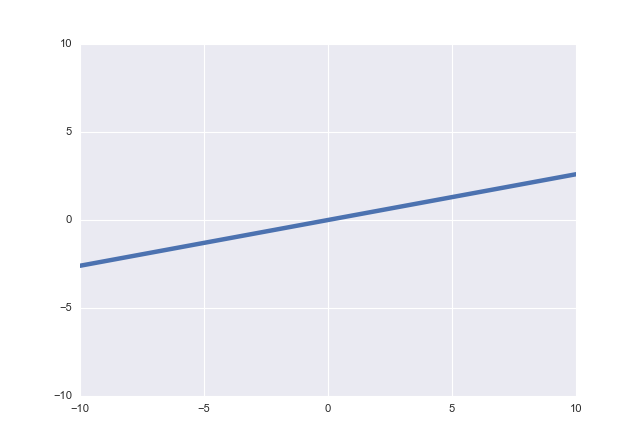

In [112]:
numDatapoints = 2500
inputValues = np.linspace(-10,10,numDatapoints)

parameters = makeLinearParameters()

LM = LinearModel(inputValues,parameters)

LM.plot()

In [113]:
LM.makeInteractive()

### Visualizing the Distribution of $y$

The above visualization lets us see the possible values of $\hat{y}$, the prediction of the model. But when we look at data, we don't get to see the true values of $\hat{y}$ directly, we only see $y$. The code below will make a linear model, then generate some random data from that model and plot it using seaborn's `jointplot` in two different ways.

Running the code more than once will generate different linear models each time. Run the cell enough times that get a sense of the diversity of models.

In [114]:
def makeLinearModel(noise_level,xMode='linspace',N=1000):
    if xMode == 'uniform':
        x = uniformInputs(-1,1,N)
    elif xMode == 'gauss':
        x = gaussInputs(0,1,N)
    elif xMode == 'linspace':
        x = linspaceInputs(-1,1,N)
    else:
        print("mode unrecognized, defaulting to linspace")
        x = linspaceInputs(-1,1,N)
        
    allOnes = np.ones(N)
    regressors = np.vstack([x,allOnes])
    
    linearWeights = randomWeights(2)
    
    epsilon = noise_level*np.random.standard_normal(size=(1,N))
    
    linearY = np.dot(linearWeights.T,regressors) + epsilon
    
    linearModelDataFrame = pd.DataFrame.from_dict({'x':np.squeeze(x),'y':np.squeeze(linearY)})
    
    return linearModelDataFrame

def uniformInputs(mn,mx,N):
    return np.random.uniform(-1,1,size=(1,N))

def gaussInputs(mn,sd,N):
    return mn+sd*np.random.standard_normal(size=(1,N))

def linspaceInputs(mn,mx,N):
    return np.linspace(mn,mx,N)

In [115]:
noise_level = 0.2
linearModelDataFrame = makeLinearModel(noise_level,xMode='linspace')

<IPython.core.display.Javascript object>


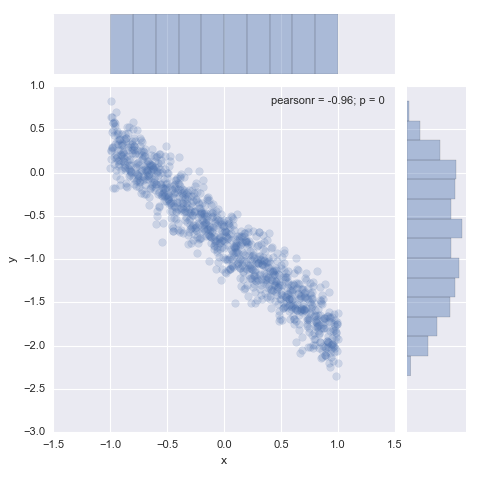

In [116]:
sns.jointplot(x='x',y='y',
              data=linearModelDataFrame,
              kind="scatter",
              joint_kws={"alpha":0.2,"s":48},);

As an alternative to the scatter plot, the code in the cell below will generate a 2-d histogram instead. Slightly unconventionally, seaborn uses hexagonal bins instead of square bins for its 2-d histograms.

<IPython.core.display.Javascript object>


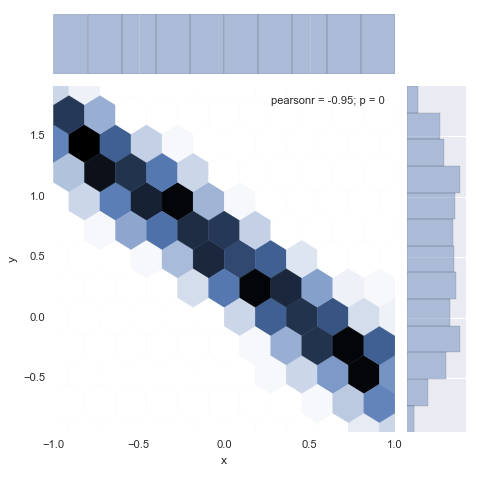

In [104]:
sns.jointplot(x='x',y='y',
              data=linearModelDataFrame,
              kind="hex",
             );

#### Q If we were to draw the model predictions in as well, where would the line go?

Changing the argument `xMode` from `linspace` to `gauss` will change the distribution of x values that the model sees. 

In `linspace` mode, evenly-spaced x values are fed into the model and the resulting y values are plotted. In `gauss` mode, the x-values are also sampled from a Gaussian distribution.

#### Q Between the two modes, which distribution of values looks more like the data distributions you see?

Say you perform an experiment where you take a linear system (a system described by a linear model) and examine its output behavior as you provide it evenly-spaced inputs from a minimum value to a maximum value.

#### Q Which distribution of values would you see?

## Linearizable Models

In [512]:
maxDegree = 20
polynomialRegressors = np.hstack([x]+ [np.ones((numDatapoints,1))]+[np.power(x,n) for n in range(2,maxDegree+1)])

In [513]:
polynomialRegressors.shape

(1000, 21)

<IPython.core.display.Javascript object>


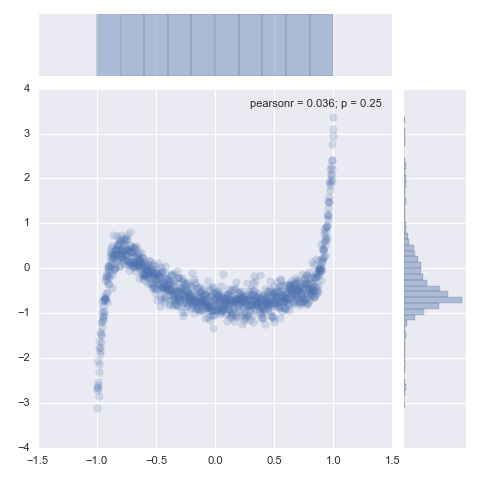

In [541]:
noise_level = 0.2

linearizedY = np.dot(polynomialRegressors,randomWeights(maxDegree+1)) + \
                    noise_level*np.random.standard_normal(size=(numDatapoints,1))

sns.jointplot(x,linearizedY,kind="scatter",joint_kws={"alpha":0.2,"s":48});

In [105]:
maxDegree = 7

transforms = makePolynomialTransforms(maxDegree)
#parameters = makeDefaultParameters(maxDegree+1,
#                                   names=['x^'+str(n) for n in range(maxDegree+1)])
#parameters = makeSineParameters(maxDegree)
parameters = makePolynomialParameters(maxDegree,rnge=0.5)


numDatapoints = 2500
inputValues = np.linspace(-10,10,numDatapoints)
M = LinearizedModel(transforms,inputValues,parameters)

<IPython.core.display.Javascript object>


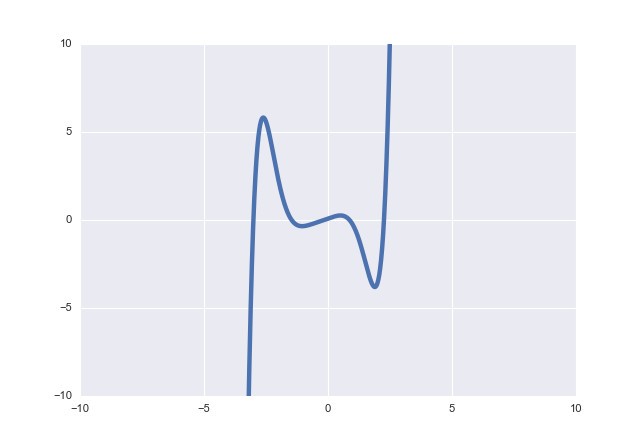

In [106]:
M.plot()

In [107]:
M.makeInteractive()

## Nonlinear Parametric Models

<IPython.core.display.Javascript object>


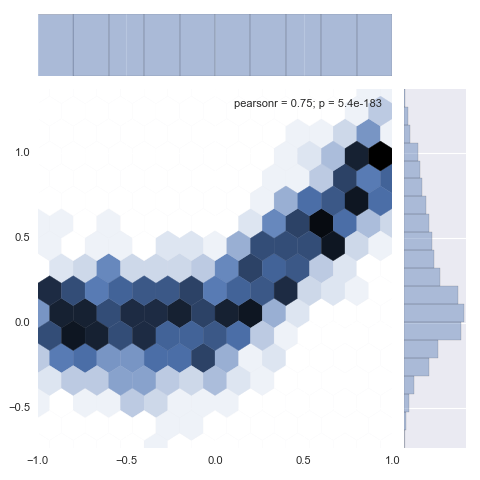

In [446]:
noise_level = 0.2

f = lambda x: np.where(x>0,x,0)

nonlinearY = f(x)+noise_level*np.random.standard_normal(size=(numDatapoints,1))

sns.jointplot(x,nonlinearY,kind="hex");

## Visualizing Model Predictions

In [ ]:
numDatapoints = 25
noise_level =0.25

minTheta = -2
maxTheta = 2
theta = np.random.uniform(minTheta,maxTheta)

xs = np.random.standard_normal(size=numDatapoints)
ys = theta*np.cos(xs)+np.random.standard_normal(size=numDatapoints)*noise_level

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)

ax.set_xlim([min(xs),max(xs)])
plt.scatter(xs,ys,color='k',s=48,alpha=0.7)

h, = plt.plot(inputs,np.cos(inputs),linewidth=4,)

In [ ]:
makeInteractive(np.cos)

In [ ]:
theta

In [ ]:
def makeInteractive(f):

    return

In [ ]:
numModels = 5 # how many models will we plot?
numDegrees = 5 # includes 0!
deltaX = 0.01 # we'll plot 

xs = np.arange(-1,1,deltaX)

regressors = np.asarray([xs**degree 
                         for degree 
                         in range(numDegrees)
                        ])

weights = np.random.standard_normal(size=(numDegrees,numModels))

In [ ]:
outputs = np.dot(weights.T,regressors)

In [ ]:
outputs.shape

In [ ]:
xs.shape

In [ ]:
plt.plot(xs,outputs.T,linewidth=4);